# Task 1

Here we will see how our nn and autograd works.

Also we will review some Catalyst's abstractions, implement callbacks and datasets.

Unfortunately, python is slow, and implementing dynamic computational graph in pure python for product-ready solution is not a good idea. But this task will help you to understand what's happening when you call `backward` method for variable or tensor. Also it will help you in learning Catalyst framework and will teach how you to write your code in more Catalyst-like way.

In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from nn import Linear, ReLU, CrossEntropyLoss, Module
from optim import SGD, StepLR
from engine import Value, Tensor
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import softmax


sns.set(style="whitegrid", font_scale=1.4)
%pylab inline

Value(data=2.4967633839867105, grad=0)
Populating the interactive namespace from numpy and matplotlib


### Defining toy dataset

To be more human-readable and easy to understand, we want to store every data in key-value format.

So, the dataset should yield dict, moreover we will store train/valid datasets in a dict.

In [2]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, item):
        return {"features": Tensor(self.X[item]), "targets": Tensor(self.y[item])}

    def __len__(self):
        return len(self.y)

X, y = make_moons(200, noise=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y)
datasets = {"train": Dataset(X_train, y_train), "valid": Dataset(X_val, y_val)}

Take a look on a data.

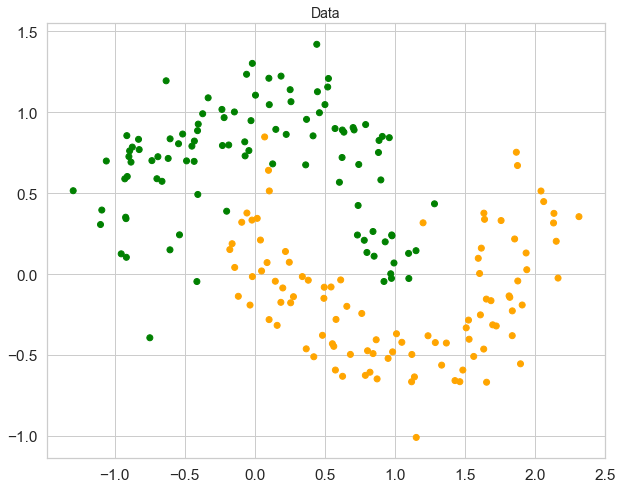

In [3]:
plt.figure(figsize=(10, 8))
plt.title("Data", fontsize=14)
colors = list(map(lambda x: "green" if x ==0 else "orange", y))
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

### Model

Let's define our model in PyTorch-style. But don't forget to implement `parameters()` method.

In [4]:
from functools import reduce


class SimpleModel(Module):
    def __init__(self):
        # Create your own network!
        self.fc = [Linear(x, y) for x, y in [(2, 15), (15, 15), (15, 2)]]
        self.relu = ReLU()

    def forward(self, inp):
        fc = [inp] + self.fc
        inp = reduce(lambda x,y: self.relu(y(x)), fc)
        return inp

    def parameters(self):
        parameters = []
        for tensor in self.fc:
            parameters += tensor.parameters()
        return parameters

## For loop

Let's start with simple train/test loop.

In [5]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, 1, 0.97)

num_epochs = 100
batch_size = 64
log_period = 5

total_loss = {'train':[], 'valid':[]}
total_acc = {'train':[], 'valid':[]}

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    scheduler.step()
    for dataset in datasets.items():
        run_loss = 0
        run_accuracy = []
        name, data = dataset
        for i in range(0, len(data), batch_size):
          input, labels = data[i: i + batch_size].values()
          outputs = model(input)
          loss = criterion(outputs, labels)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          run_loss += len(labels.data)*loss.data
          run_accuracy.append((outputs.argmax(-1) == labels.data).sum()/len(labels.data))

        epoch_loss = run_loss/len(data)
        epoch_accuracy = sum(run_accuracy)/len(run_accuracy)
        total_loss[name].append(epoch_loss)
        total_acc[name].append(epoch_accuracy)
        print(f'{name} loss: {epoch_loss}')
        print(f'{name} accuracy: {epoch_accuracy}')

train loss: 0.6624256842873566
train accuracy: 0.7817234848484849
valid loss: 0.6044015693798417
valid accuracy: 0.84
train loss: 0.5551686611935555
train accuracy: 0.8702651515151515
valid loss: 0.48185717713028287
valid accuracy: 0.86
train loss: 0.4601502992690548
train accuracy: 0.8702651515151515
valid loss: 0.39956738236226874
valid accuracy: 0.86
train loss: 0.403926863307895
train accuracy: 0.8854166666666666
valid loss: 0.3602787037991471
valid accuracy: 0.88
train loss: 0.37042000233269917
train accuracy: 0.8854166666666666
valid loss: 0.34143362127288285
valid accuracy: 0.88
train loss: 0.3565961068860827
train accuracy: 0.8854166666666666
valid loss: 0.3301451938402091
valid accuracy: 0.88
train loss: 0.3496988705876125
train accuracy: 0.8854166666666666
valid loss: 0.3210674518083706
valid accuracy: 0.88
train loss: 0.34590612487179223
train accuracy: 0.875
valid loss: 0.3140750857646716
valid accuracy: 0.88
train loss: 0.3378929266987698
train accuracy: 0.8802083333333334

train loss: 0.2843165804940019
train accuracy: 0.8754734848484849
valid loss: 0.21992535211781938
valid accuracy: 0.88
train loss: 0.2839796844311701
train accuracy: 0.8806818181818182
valid loss: 0.21961320107706608
valid accuracy: 0.88
train loss: 0.28366147427852384
train accuracy: 0.8806818181818182
valid loss: 0.21929832867560978
valid accuracy: 0.88
train loss: 0.2833476509985626
train accuracy: 0.8858901515151515
valid loss: 0.21899155063571837
valid accuracy: 0.88
train loss: 0.28304135293762767
train accuracy: 0.8858901515151515
valid loss: 0.21869333632990917
valid accuracy: 0.88
train loss: 0.2827372556215446
train accuracy: 0.8858901515151515
valid loss: 0.2184045203676553
valid accuracy: 0.88
train loss: 0.2824357337019848
train accuracy: 0.8858901515151515
valid loss: 0.2181360831163115
valid accuracy: 0.88
train loss: 0.2821575833593753
train accuracy: 0.8858901515151515
valid loss: 0.21785283035625164
valid accuracy: 0.88
train loss: 0.28187132825075994
train accuracy: 

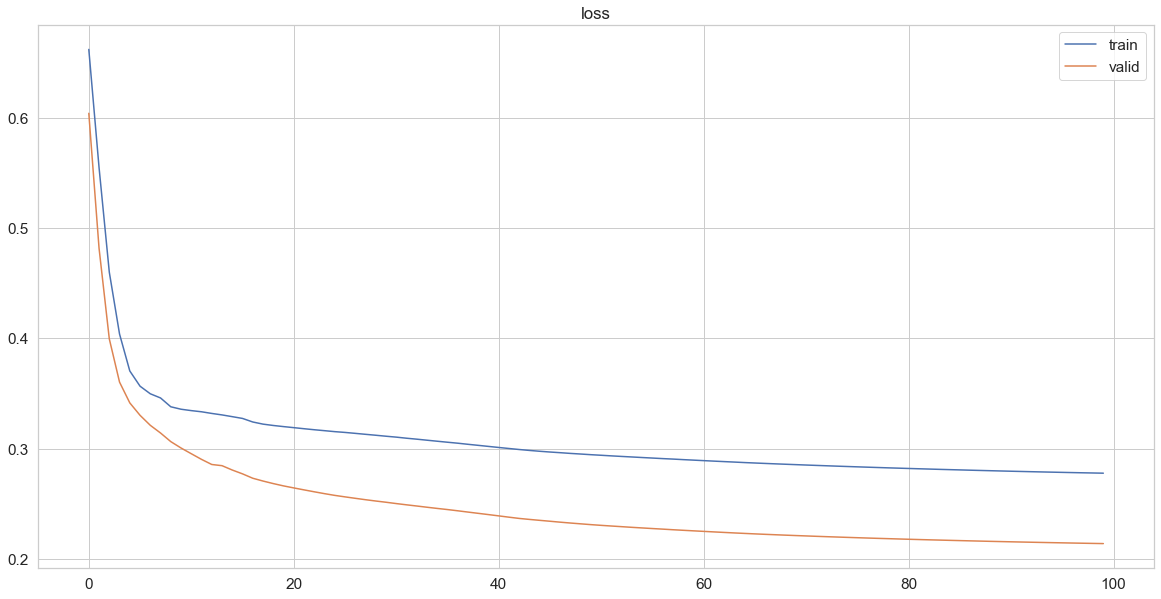

In [6]:
plt.figure(figsize=(20,10))
plt.plot(total_loss['train'], label = 'train')
plt.plot(total_loss['valid'], label = 'valid')
plt.title('loss')
plt.legend()

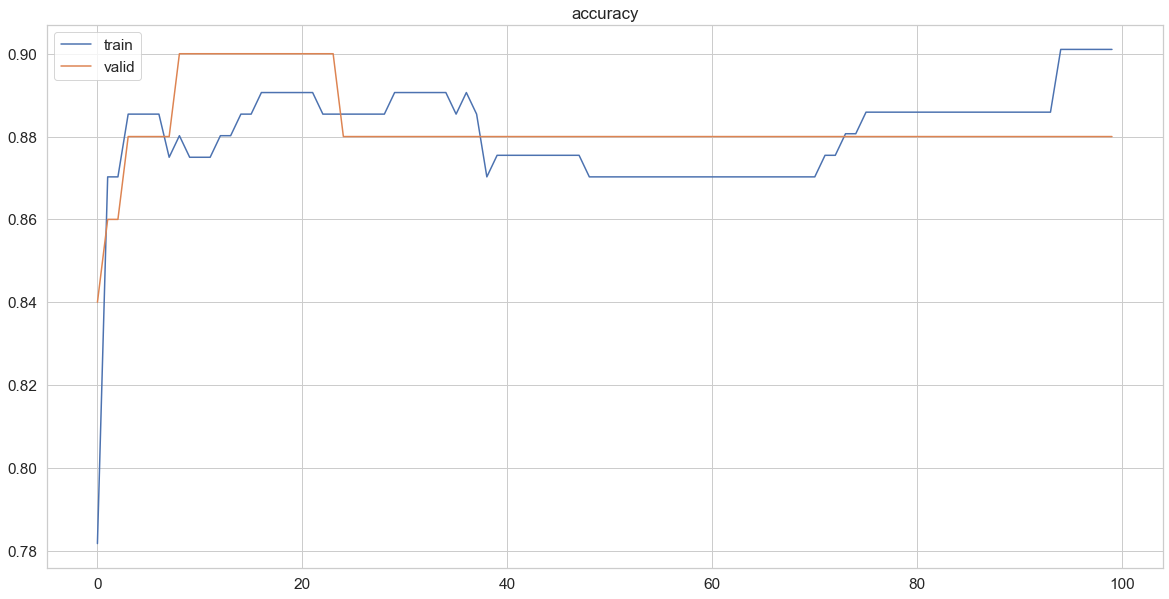

In [7]:
plt.figure(figsize=(20,10))
plt.plot(total_acc['train'], label = 'train')
plt.plot(total_acc['valid'], label = 'valid')
plt.title('accuracy')
plt.legend()

(-1.6634787585465893, 2.3365212414534104)

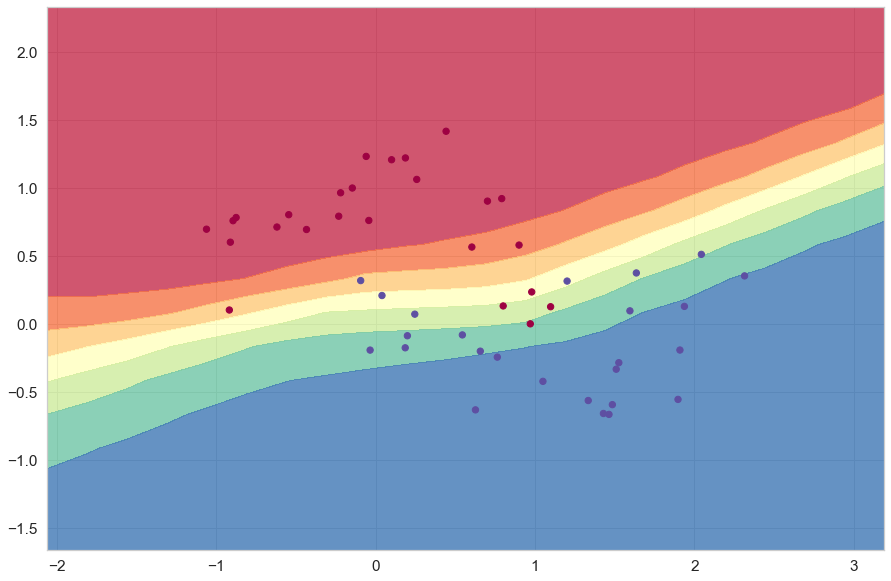

In [8]:
h = 0.25
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh)
scores = softmax(model(inputs).data, axis = 1)[:, 1]
Z = scores.reshape(xx.shape)

fig = plt.figure(figsize = (15, 10))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


## General training loop - Catalyst intro - Runner¶

Code above can be reused for almost all machine learning task. Let's take a look on experiment structure

```
for stage in stage:
    for epoch in epochs:
        for loader on loaders:
            for batch in loader:
                # do something
```

### Runner

In most cases we only need to adapt our batch handling method. And here comes the Runner.

Runner is the main part of your experiment. It runs train loop, calls callbacks (we will discusds them later) and keeps track on your model. And the only thing you need to change is _handle_batch method.


In [9]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size

        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch, train=True):
        """
        Stores the main logic of data aggregating.
        """
        input = Tensor(np.vstack([data['features'].data  for data in batch]))
        labels = Tensor(np.stack([data['targets'].data for data in batch]))
        
        outputs = self.model(input)
        loss = self.criterion(outputs, labels)
        correct = (outputs.argmax(-1) == labels.data).sum()
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        accuracy = correct / len(batch)

        self.batch_metrics = {"loss": loss.data, "accuracy": accuracy}


    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        # Handle batch
                        self._handle_batch(current_batch)
                        current_batch = []

                        for k, v in self.batch_metrics.items():
                            if k not in self.loader_metrics:
                                self.loader_metrics[k] = []
                            self.loader_metrics[k].append(v)
                
                for metric, value in self.loader_metrics.items():
                    value = np.mean(self.loader_metrics[metric])
                    self.loader_metrics[metric] = value
                    print(f"epoch {epoch}: {dataset_name} {metric} - {value}")

### Run training

In [10]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.01)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=64
)
runner.train(50, verbose = True)


epoch 0: train loss - 0.6841264541370605
epoch 0: train accuracy - 0.5464015151515151



epoch 0: valid loss - 0.6706869789263371
epoch 0: valid accuracy - 0.58



epoch 1: train loss - 0.6545639580250376
epoch 1: train accuracy - 0.6349431818181818



epoch 1: valid loss - 0.6430400562264899
epoch 1: valid accuracy - 0.52



epoch 2: train loss - 0.6195226848678503
epoch 2: train accuracy - 0.6813446969696969



epoch 2: valid loss - 0.6066631519293154
epoch 2: valid accuracy - 0.76



epoch 3: train loss - 0.5855925968236915
epoch 3: train accuracy - 0.7225378787878788



epoch 3: valid loss - 0.573000949901842
epoch 3: valid accuracy - 0.76



epoch 4: train loss - 0.5548465428938907
epoch 4: train accuracy - 0.8186553030303031



epoch 4: valid loss - 0.5481353538889389
epoch 4: valid accuracy - 0.8



epoch 5: train loss - 0.5344648614751006
epoch 5: train accuracy - 0.8342803030303031



epoch 5: valid loss - 0.5309178360587442
epoch 5: valid accuracy - 0.84



epoch 6: train loss - 0.52019547134639
epoch 6: train accuracy - 0.875



epoch 6: valid loss - 0.5221508879700665
epoch 6: valid accuracy - 0.88



epoch 7: train loss - 0.5181785305366267
epoch 7: train accuracy - 0.8645833333333334



epoch 7: valid loss - 0.5153973290240548
epoch 7: valid accuracy - 0.88



epoch 8: train loss - 0.5039352864415877
epoch 8: train accuracy - 0.9010416666666666



epoch 8: valid loss - 0.5140019809285209
epoch 8: valid accuracy - 0.88



epoch 9: train loss - 0.5042540068002643
epoch 9: train accuracy - 0.8958333333333334



epoch 9: valid loss - 0.5096518467216403
epoch 9: valid accuracy - 0.88



epoch 10: train loss - 0.5030950638622397
epoch 10: train accuracy - 0.890625



epoch 10: valid loss - 0.5061401459417908
epoch 10: valid accuracy - 0.88



epoch 11: train loss - 0.49936970184215923
epoch 11: train accuracy - 0.8958333333333334



epoch 11: valid loss - 0.5047047821288618
epoch 11: valid accuracy - 0.88



epoch 12: train loss - 0.49833986348327874
epoch 12: train accuracy - 0.8958333333333334



epoch 12: valid loss - 0.5027079150915355
epoch 12: valid accuracy - 0.88



epoch 13: train loss - 0.49739019871022533
epoch 13: train accuracy - 0.8958333333333334



epoch 13: valid loss - 0.5011125037219661
epoch 13: valid accuracy - 0.9



epoch 14: train loss - 0.49499978382889775
epoch 14: train accuracy - 0.9010416666666666



epoch 14: valid loss - 0.5015821117888072
epoch 14: valid accuracy - 0.88



epoch 15: train loss - 0.4939100085549705
epoch 15: train accuracy - 0.9010416666666666



epoch 15: valid loss - 0.5006460175939218
epoch 15: valid accuracy - 0.9



epoch 16: train loss - 0.4941888103451341
epoch 16: train accuracy - 0.9010416666666666



epoch 16: valid loss - 0.4998135751584163
epoch 16: valid accuracy - 0.9



epoch 17: train loss - 0.49354816958279185
epoch 17: train accuracy - 0.9010416666666666



epoch 17: valid loss - 0.4990296158918712
epoch 17: valid accuracy - 0.9



epoch 18: train loss - 0.49301596080769866
epoch 18: train accuracy - 0.9010416666666666



epoch 18: valid loss - 0.49832960094634887
epoch 18: valid accuracy - 0.9



epoch 19: train loss - 0.4923391924575286
epoch 19: train accuracy - 0.9010416666666666



epoch 19: valid loss - 0.4975959400225017
epoch 19: valid accuracy - 0.9



epoch 20: train loss - 0.49149184727989476
epoch 20: train accuracy - 0.9010416666666666



epoch 20: valid loss - 0.4968449497963272
epoch 20: valid accuracy - 0.9



epoch 21: train loss - 0.49095437067032327
epoch 21: train accuracy - 0.9010416666666666



epoch 21: valid loss - 0.4959964511919307
epoch 21: valid accuracy - 0.9



epoch 22: train loss - 0.49000757879564744
epoch 22: train accuracy - 0.9010416666666666



epoch 22: valid loss - 0.49507810790445084
epoch 22: valid accuracy - 0.9



epoch 23: train loss - 0.4892924367727864
epoch 23: train accuracy - 0.9010416666666666



epoch 23: valid loss - 0.4938974506736707
epoch 23: valid accuracy - 0.9



epoch 24: train loss - 0.4882887031070901
epoch 24: train accuracy - 0.9010416666666666



epoch 24: valid loss - 0.492615919751624
epoch 24: valid accuracy - 0.9



epoch 25: train loss - 0.4900035991257254
epoch 25: train accuracy - 0.890625



epoch 25: valid loss - 0.4917804907006519
epoch 25: valid accuracy - 0.92



epoch 26: train loss - 0.4900245492297661
epoch 26: train accuracy - 0.890625



epoch 26: valid loss - 0.4909089010915355
epoch 26: valid accuracy - 0.92



epoch 27: train loss - 0.48680305805958807
epoch 27: train accuracy - 0.8958333333333334



epoch 27: valid loss - 0.4907820089257025
epoch 27: valid accuracy - 0.92



epoch 28: train loss - 0.4863305912010445
epoch 28: train accuracy - 0.8958333333333334



epoch 28: valid loss - 0.4896150063906303
epoch 28: valid accuracy - 0.92



epoch 29: train loss - 0.4854828442121602
epoch 29: train accuracy - 0.8958333333333334



epoch 29: valid loss - 0.48814066954495333
epoch 29: valid accuracy - 0.92



epoch 30: train loss - 0.48411080537198775
epoch 30: train accuracy - 0.8958333333333334



epoch 30: valid loss - 0.486223566054387
epoch 30: valid accuracy - 0.9



epoch 31: train loss - 0.4817748069665228
epoch 31: train accuracy - 0.8958333333333334



epoch 31: valid loss - 0.48410631096478945
epoch 31: valid accuracy - 0.9



epoch 32: train loss - 0.48040408988385036
epoch 32: train accuracy - 0.8958333333333334



epoch 32: valid loss - 0.4820087790663267
epoch 32: valid accuracy - 0.9



epoch 33: train loss - 0.4785491411530745
epoch 33: train accuracy - 0.8958333333333334



epoch 33: valid loss - 0.4803166674873598
epoch 33: valid accuracy - 0.9



epoch 34: train loss - 0.4769912800895768
epoch 34: train accuracy - 0.8958333333333334



epoch 34: valid loss - 0.4785678424427098
epoch 34: valid accuracy - 0.9



epoch 35: train loss - 0.4755838994623331
epoch 35: train accuracy - 0.8958333333333334



epoch 35: valid loss - 0.4764542494382233
epoch 35: valid accuracy - 0.9



epoch 36: train loss - 0.4737675041312403
epoch 36: train accuracy - 0.8958333333333334



epoch 36: valid loss - 0.4743307254554149
epoch 36: valid accuracy - 0.9



epoch 37: train loss - 0.47176974101303265
epoch 37: train accuracy - 0.8958333333333334



epoch 37: valid loss - 0.4719880614480142
epoch 37: valid accuracy - 0.9



epoch 38: train loss - 0.4700990195450783
epoch 38: train accuracy - 0.8958333333333334



epoch 38: valid loss - 0.4698701480333734
epoch 38: valid accuracy - 0.9



epoch 39: train loss - 0.4677301402140725
epoch 39: train accuracy - 0.8958333333333334



epoch 39: valid loss - 0.46739989801172555
epoch 39: valid accuracy - 0.9



epoch 40: train loss - 0.46302885685667605
epoch 40: train accuracy - 0.9010416666666666



epoch 40: valid loss - 0.46837126123753725
epoch 40: valid accuracy - 0.9



epoch 41: train loss - 0.46114648958409266
epoch 41: train accuracy - 0.9010416666666666



epoch 41: valid loss - 0.4656353062847981
epoch 41: valid accuracy - 0.9



epoch 42: train loss - 0.4608887605218979
epoch 42: train accuracy - 0.9010416666666666



epoch 42: valid loss - 0.45901351697150494
epoch 42: valid accuracy - 0.9



epoch 43: train loss - 0.4552161551643092
epoch 43: train accuracy - 0.90625



epoch 43: valid loss - 0.45950754689069134
epoch 43: valid accuracy - 0.9



epoch 44: train loss - 0.4536052023674064
epoch 44: train accuracy - 0.90625



epoch 44: valid loss - 0.456522641067064
epoch 44: valid accuracy - 0.9



epoch 45: train loss - 0.44869656532266505
epoch 45: train accuracy - 0.9166666666666666



epoch 45: valid loss - 0.45333351074109074
epoch 45: valid accuracy - 0.92



epoch 46: train loss - 0.4487842915824786
epoch 46: train accuracy - 0.9114583333333334



epoch 46: valid loss - 0.4493295172499457
epoch 46: valid accuracy - 0.92



epoch 47: train loss - 0.44655161055429476
epoch 47: train accuracy - 0.9114583333333334



epoch 47: valid loss - 0.44511536401256047
epoch 47: valid accuracy - 0.92



epoch 48: train loss - 0.4427788596640399
epoch 48: train accuracy - 0.9166666666666666



epoch 48: valid loss - 0.44087124336148437
epoch 48: valid accuracy - 0.92



epoch 49: train loss - 0.437809116021001
epoch 49: train accuracy - 0.921875



epoch 49: valid loss - 0.43665550704598655
epoch 49: valid accuracy - 0.92


### Visualization

(-1.6634787585465893, 2.3365212414534104)

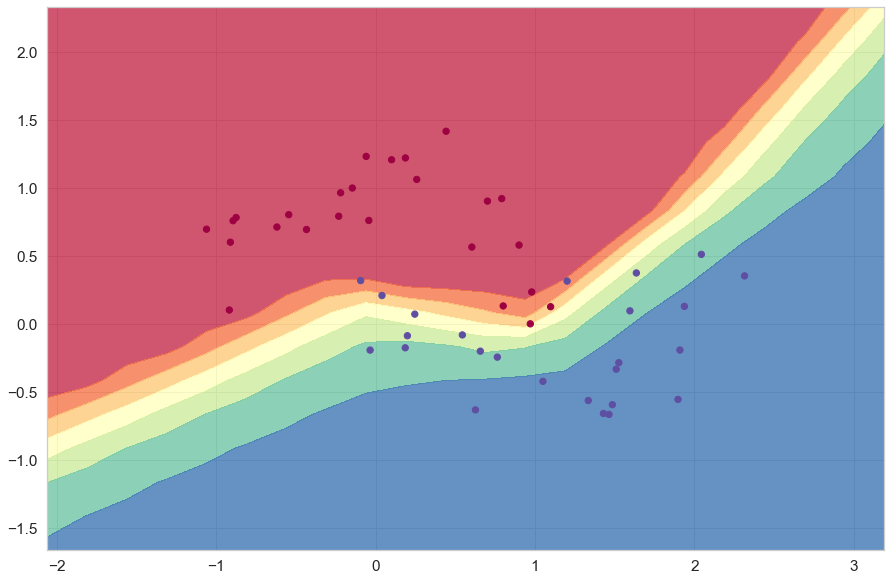

In [11]:
h = 0.25
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh)
scores = softmax(model(inputs).data, axis = 1)[:, 1]
Z = scores.reshape(xx.shape)

fig = plt.figure(figsize = (15, 10))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


## General training loop - Catalyst intro - Callbacks

But could we make it even more general? Should we rewrite loss.backward or compute accuracy again and again? Do we really need it?

I don't think so, I think, we could introduce another general abstaction for typical train-loop logic. Let's introduce Callbacks!

### Callbacks

In catalyst callbacks have significant impact in everything you do.
Let's try to implement some of them.

There are a list of moments, where callbacks can be integrated. We will need only three of them.
```
on_stage_start
    on_epoch_start
        on_loader_start
            on_batch_start
------->    on_batch_end
----->  on_loader_end
--> on_epoch_end
on_stage_end
```

In [12]:
class Callback:
    def on_stage_start(self):
        pass

    def on_stage_end(self):
        pass

    def on_epoch_start(self):
        pass

    def on_epoch_end(self, runner):
        pass

    def on_loader_start(self):
        pass

    def on_loader_end(self, runner):
        pass

    def on_batch_start(self, runner):
        pass

    def on_batch_end(self, runner):
        pass


class LossCallback(Callback):
    """
    Aggregating loss value.
    """
    def __init__(self):
        self.cum_loss = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action.

        Accumulates loss and num batches.

        Args:
            output: dict with loss and other model's outputs.
        """
        self.cum_loss += runner.output["loss"]
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            loss over the loader.
        """
        runner.epoch_metrics["loss"] = self.cum_loss / self.num_batches
        self.cum_loss = 0
        self.num_batches = 0


class AccuracyCallback(Callback):
    """
    Aggregating accuracy value.
    """
    def __init__(self):
        self.correct = 0
        self.num_batches = 0

    def on_batch_end(self, runner):
        """
        On batch end action

        Accumulates number of correct predictions.

        Args:
            output: dict with number of the correct predictions
        """
        self.correct +=  runner.output['accuracy']
        self.num_batches += 1

    def on_loader_end(self, runner):
        """
        On loader end action.

        Args:
            epoch_metrics: dict with epoch metrics

        Returns:
            accuracy value over the loader.
        """
        runner.epoch_metrics["accuracy"] = self.correct/self.num_batches
        self.correct=0
        self.num_batches = 0


class LoggerCallback(Callback):
    """
    Log metrics to output.
    """
    def __init__(self, log_period):
        self.log_period = log_period

    def on_epoch_end(self, runner):
        """
        On epoch end action.

        Prints all epoch metrics if log_period is suitable.

        Args:
            epoch_metrics: dict with epoch metrics
            epoch: current epoch
        """
        if runner.epoch % self.log_period == 0:
            log_string = f"Epoch: {runner.epoch}\n"
            for metric, value in runner.epoch_metrics.items():
                log_string += f"{runner.dataset_name}: {metric} - {value}\n"
            print(log_string)


class OptimizerCallback(Callback):
    def on_batch_start(self, runner):
        if runner.dataset_name == "train":
            runner.optimizer.zero_grad()

    def on_batch_end(self, runner):
        loss = 0
        current_loss = runner.criterion(runner.output["output"], runner.input)
        loss += current_loss
        
        loss = loss / len(runner.input.data)
        
        if runner.dataset_name == "train":
            current_loss.backward()
            runner.optimizer.step()

In [13]:
from tqdm.notebook import tqdm


class Runner:
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        datasets,
        batch_size,
        callbacks,
    ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.datasets = datasets

        self.batch_size = batch_size
        self.callbacks = callbacks
        
        self.input = {}
        self.output = {}
        self.batch_metrics = {}
        self.loader_metrcis = {}
        self.epoch_metrics = {}

    def _handle_batch(self, batch):
        """
        Stores the main logic of data aggregating.
        """
        input = Tensor(np.vstack([data['features'].data if len(data['features'].shape()) != 2 else \
                                  data['features'].data[None, ...] for data in batch]))
        labels = Tensor(np.stack([data['targets'].data for data in batch]))
        
        outputs = self.model(input)
        loss = self.criterion(outputs, labels)
        correct = (outputs.argmax(-1) == labels.data).sum()
            
        accuracy = correct / len(batch)

        self.output = {"loss": loss.data, "accuracy": accuracy, "output": outputs}
        self.input = labels

    def train(self, num_epochs: int = 100, verbose=False):
        for epoch in range(num_epochs):
            self.epoch_metrics = {}
            self.epoch = epoch
            for dataset_name, dataset in self.datasets.items():
                self.dataset_name = dataset_name
                self.loader_metrics = {}
                current_batch = []

                if verbose:
                    iter_ = tqdm(enumerate(dataset), total=len(dataset))
                else:
                    iter_ = enumerate(dataset)

                for idx, data in iter_:
                    last = idx == (len(dataset)-1)
                    current_batch.append(data)

                    if last or len(current_batch) == self.batch_size:
                        self._handle_batch(current_batch)
                        for clb in self.callbacks.values():
                            clb.on_batch_start(self)

                        # Handle batch
                        current_batch = []

                        for clb in self.callbacks.values():
                            clb.on_batch_end(self)

                for clb in self.callbacks.values():
                    clb.on_loader_end(self)
                    clb.on_epoch_end(self)

### Run training

In [14]:
criterion = CrossEntropyLoss()
model = SimpleModel()
optimizer = SGD(model.parameters(), lr=0.01)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=32,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=5),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(50)

Epoch: 0
train: loss - 0.6845163519203623
train: accuracy - 0.5840909090909091

Epoch: 0
valid: loss - 0.6741748613401175
valid: accuracy - 0.4913194444444444

Epoch: 5
train: loss - 0.5770178079676798
train: accuracy - 0.7642045454545455

Epoch: 5
valid: loss - 0.5618537181784544
valid: accuracy - 0.8072916666666667

Epoch: 10
train: loss - 0.5259965509548391
train: accuracy - 0.847159090909091

Epoch: 10
valid: loss - 0.5236560394845184
valid: accuracy - 0.8784722222222222

Epoch: 15
train: loss - 0.5113298222264716
train: accuracy - 0.872159090909091

Epoch: 15
valid: loss - 0.5095612467269884
valid: accuracy - 0.8784722222222222

Epoch: 20
train: loss - 0.5012792904315015
train: accuracy - 0.872159090909091

Epoch: 20
valid: loss - 0.4990761480644927
valid: accuracy - 0.8784722222222222

Epoch: 25
train: loss - 0.49396472830926585
train: accuracy - 0.88125

Epoch: 25
valid: loss - 0.4896730198743525
valid: accuracy - 0.8784722222222222

Epoch: 30
train: loss - 0.48646092868749813
t

### Visualization

(-1.6634787585465893, 2.3365212414534104)

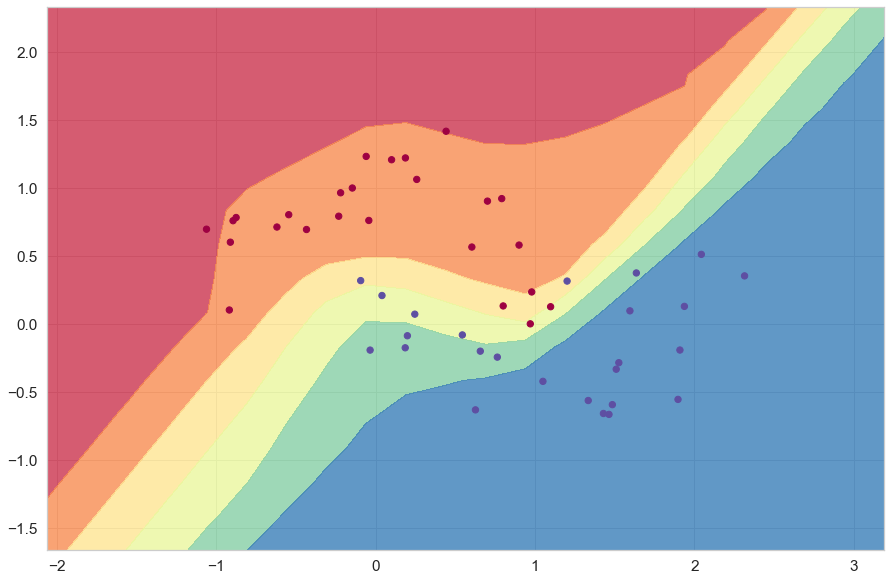

In [15]:
h = 0.25
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh)
scores = softmax(model(inputs).data, axis = 1)[:, 1]
Z = scores.reshape(xx.shape)

fig = plt.figure(figsize = (15, 10))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## MNIST

Try to train model on MNIST task!

In [16]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [54]:
class MNISTDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return {"features": Tensor(self.x[idx]), "targets": Tensor(self.y[idx])}

    def __len__(self):
        return len(self.y)

# Python is slow, that's why we use only small group of object
datasets = {
    "train": MNISTDataset(X_train[:2000], y_train[:2000]),
    "valid": MNISTDataset(X_val[:1000], y_val[:1000])
} 

In [55]:
class MnistModel(Module):
    def __init__(
        self,
        inp_shape=28*28,
        out_shape=10,
        hidden_shapes=[10, 10]
    ):
        self.inp_shape = inp_shape
        self.fc_1 = Linear(inp_shape, hidden_shapes[0])
        self.fc_2 = Linear(*hidden_shapes)
        self.fc_3 = Linear(hidden_shapes[1], 10)
        self.relu = ReLU()

    def forward(self, inp):
        inp = inp.reshape((inp.shape()[0], self.inp_shape))
        inp = self.relu(self.fc_1(inp))
        inp = self.relu(self.fc_2(inp))
        inp = self.fc_3(inp)
        return inp

    def parameters(self):
        parameters = self.fc_1.parameters() + self.fc_2.parameters() + self.fc_3.parameters()
        return parameters

In [56]:
batch_size = 64
criterion = CrossEntropyLoss()
model = MnistModel()
optimizer = SGD(model.parameters(), lr=0.01)
runner = Runner(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    datasets=datasets,
    batch_size=batch_size,
    callbacks={
        "loss": LossCallback(),
        "accuracy": AccuracyCallback(),
        "logger": LoggerCallback(log_period=1),
        "optimizer": OptimizerCallback(),
    }
)
runner.train(10)

Epoch: 0
train: loss - 1.9628716533506991
train: accuracy - 0.2880859375

Epoch: 0
valid: loss - 1.4916312933059988
valid: accuracy - 0.479296875

Epoch: 1
train: loss - 1.2507235492497344
train: accuracy - 0.5576171875

Epoch: 1
valid: loss - 0.8788955730699625
valid: accuracy - 0.709765625

Epoch: 2
train: loss - 0.9337408670642812
train: accuracy - 0.67578125

Epoch: 2
valid: loss - 0.8101888012707594
valid: accuracy - 0.7296875

Epoch: 3
train: loss - 0.6704761661246551
train: accuracy - 0.77099609375

Epoch: 3
valid: loss - 0.6420970168936899
valid: accuracy - 0.7908203125

Epoch: 4
train: loss - 0.5166200923830792
train: accuracy - 0.84326171875

Epoch: 4
valid: loss - 0.5479626394900069
valid: accuracy - 0.8396484375

Epoch: 5
train: loss - 0.5143094337577511
train: accuracy - 0.83837890625

Epoch: 5
valid: loss - 0.5955302442908637
valid: accuracy - 0.82578125

Epoch: 6
train: loss - 0.4026221987545003
train: accuracy - 0.87744140625

Epoch: 6
valid: loss - 0.5330483562104339
v

In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X = tsne.fit_transform(X_val[:1000].reshape((-1,28*28)))

Text(0.5, 1.0, 'Predicted projections')

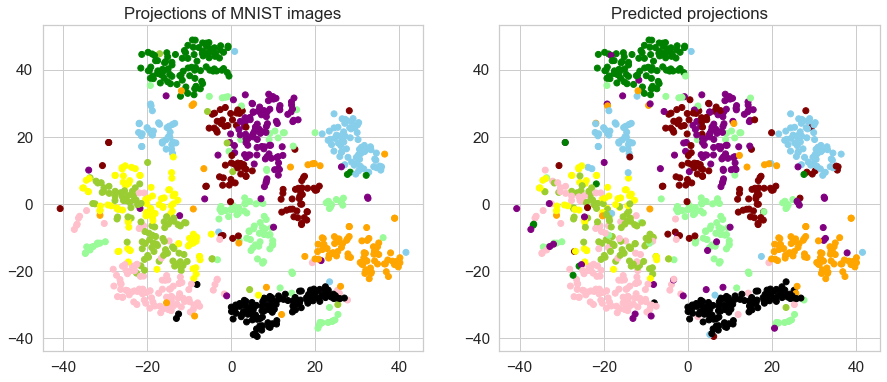

In [70]:
val_to_color = {0: "green",
                1: "black",
                2: "orange",
                3: "purple",
                4: "yellow",
                5: "maroon",
                6: "skyblue",
                7: "pink",
                8: "palegreen",
                9: "yellowgreen"}
colors_1 = list(map(lambda x: val_to_color[x], y_val[:1000]))

inputs = Tensor(X_val[:1000])
scores = softmax(model(inputs).data, axis = 1)
y = np.argmax(scores, -1)

colors_2 = list(map(lambda x: val_to_color[x], y))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(X[:, 0], X[:, 1], c=colors_1)
axs[0].set_title('Projections of MNIST images')
axs[1].scatter(X[:, 0], X[:, 1], c=colors_2)
axs[1].set_title('Predicted projections')